In [1]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from PIL import Image
import numpy as np
import seaborn as sns

In [2]:
# CONSTANTS
DISPSIZE = (2560, 1440) # Display Resolution
DISPSIZE = (1280, 990) # Display Resolution
MAXIMAL_DISTANCE = 25 # Eucledian Distance Fixation Calculation (Dispersion)
MINIMAL_DURATION = 50 # Minimal duration to be considered a fixation in milliseconds (typically 50 - 200)

def prepare_raw_data(gazeData, dataset):
    if gazeData.empty:
        print("Warning: gazeData is empty. Skipping processing.")
        return

    #gazeData = filter_valid_entries(gazeData)
    #gazeData = get_xy_coordinates(gazeData)
    gazeData = compute_mean_gaze_point(gazeData)
    gazeData = filterOffDisplayValues(gazeData)
    timestamps = getTimestampsInMilliseconds(gazeData)
    time = pd.Series(timestamps)
    gazeData = gazeData.assign(Timestamp=time.values)
    gazeData.reset_index()

    x_gazePoints, width = getXGazePointsAsPixel(gazeData)
    y_gazePoints, height = getYGazePointsAsPixel(gazeData)
    s = pd.Series(x_gazePoints)
    t = pd.Series(y_gazePoints)
    gazeData = gazeData.assign(PixelPointX=s.values)
    gazeData = gazeData.assign(PixelPointY=t.values)
    gazeData = remove_noise_df(gazeData)
    gazeData = calculate_isd(gazeData)
    gazeData = add_velocity_df(gazeData)

    gazeData.to_csv(dataset, index=False, na_rep='NaN')

def get_xy_coordinates(dataframe):
    def process_cell(cell_value):
        cell_value = cell_value.strip('()')  
        values = cell_value.split(',')  
        return [float(value) for value in values]  
        
    dataframe['left_gaze_point_on_display_area'] = dataframe['left_gaze_point_on_display_area'].apply(process_cell)
    dataframe['left_gaze_point_x'] = dataframe['left_gaze_point_on_display_area'].apply(lambda x: x[0])
    dataframe['left_gaze_point_y'] = dataframe['left_gaze_point_on_display_area'].apply(lambda x: x[1])
        
    dataframe['right_gaze_point_on_display_area'] = dataframe['right_gaze_point_on_display_area'].apply(process_cell)

    dataframe['right_gaze_point_x'] = dataframe['right_gaze_point_on_display_area'].apply(lambda x: x[0])
    dataframe['right_gaze_point_y'] = dataframe['right_gaze_point_on_display_area'].apply(lambda x: x[1])

    return dataframe

def event_detecting_smoothing(csv_file):
    event_df = pd.read_csv(csv_file)
    if event_df.empty:
        print("Warning: event_df is empty. Skipping processing.")
        return
    else:
        gazeData = mark_events_saccade_blink_noise(csv_file)
        gazeData = smooth_gaze_data(gazeData)
        gazeData.to_csv(csv_file, index=False, na_rep='NaN')

def get_fixations(csv_file):
    gazeData = pd.read_csv(csv_file)
    timestamps = getTimestampsInMilliseconds(gazeData)
    x_gazePoints = gazeData.SmoothPixelPointX
    y_gazePoints = gazeData.SmoothPixelPointY
    fixations_all_data = FilterDataWithFixations_weighted_mean(x_gazePoints, y_gazePoints, timestamps, mindur=50)
    fixations = []
    for fixation_data in fixations_all_data:
        start_time, end_time, duration, mean_x, mean_y, _ = fixation_data  # Ignore fixation points
        fixations.append([start_time, end_time, duration, mean_x, mean_y])
    return fixations



''' Fixation Algorithm'''

class Point:
    def __init__(self, x, y):
        self.x = x
        self.y = y


def calculate_distance(point1, point2):
    # Calculate the Euclidean distance between two points
    return ((point1.x - point2.x) ** 2 + (point1.y - point2.y) ** 2) ** 0.5

def calculate_weighted_mean(points):
    # Calculate the weighted mean of a list of points
    n = len(points)
    weighted_x_sum = sum((i + 1) * point.x for i, point in enumerate(points))
    weighted_y_sum = sum((i + 1) * point.y for i, point in enumerate(points))
    total_weight = (n * (n + 1)) / 2  # Sum of weights from 1 to n

    if total_weight == 0:
        return None  # Avoid division by zero

    mean_x = weighted_x_sum / total_weight
    mean_y = weighted_y_sum / total_weight

    return Point(mean_x, mean_y)

def FilterDataWithFixations_weighted_mean(x, y, time, saccade_threshold=MAXIMAL_DISTANCE, maxdist=MAXIMAL_DISTANCE, mindur=MINIMAL_DURATION):
    fixations = []

    current_fixation = []

    for i in range(len(x)):
        current_point = Point(x[i], y[i])

        if not current_fixation:
            current_fixation.append(current_point)
            continue

        last_fixation_point = current_fixation[-1]
        distance_to_current = calculate_distance(current_point, last_fixation_point)

        if distance_to_current < saccade_threshold:
            current_fixation.append(current_point)
        else:
            if current_fixation:
                # Check if the current fixation is valid (meets duration criteria)
                start_time = time[i - len(current_fixation)]
                end_time = time[i - 1]
                duration = end_time - start_time
                if duration >= mindur:
                    weighted_mean = calculate_weighted_mean(current_fixation)
                    if weighted_mean is not None:
                        fixations.append([start_time, end_time, duration, weighted_mean.x, weighted_mean.y, current_fixation])
                current_fixation = []

    # Check if there's any remaining fixation
    if current_fixation:
        start_time = time[len(x) - len(current_fixation)]
        end_time = time[-1]
        duration = end_time - start_time
        if duration >= mindur:
            weighted_mean = calculate_weighted_mean(current_fixation)
            if weighted_mean is not None:
                fixations.append([start_time, end_time, duration, weighted_mean.x, weighted_mean.y, current_fixation])

    return fixations


''' Helper Functions'''

# Monoccular
def filter_valid_entries(dataframe):
    valid_rows = dataframe[(dataframe['left_gaze_point_validity'] == 1) | (dataframe['right_gaze_point_validity'] == 1)]
    return valid_rows


def compute_mean_gaze_point(dataframe):
    actualGazePointX = []
    actualGazePointY = []

    for index, row in dataframe.iterrows():
        leftX = row['left_gaze_point_x']
        leftY = row['left_gaze_point_y']
        rightX = row['right_gaze_point_x']
        rightY = row['right_gaze_point_y']

        if not np.isnan(leftX) and not np.isnan(leftY) and not np.isnan(rightX) and not np.isnan(rightY):
            actualX = (leftX + rightX) / 2
            actualY = (leftY + rightY) / 2
        elif np.isnan(leftX) and np.isnan(leftY):
            actualX = rightX
            actualY = rightY
        elif np.isnan(rightX) and np.isnan(rightY):
            actualX = leftX
            actualY = leftY

        actualGazePointX.append(actualX)
        actualGazePointY.append(actualY)

    s = pd.Series(actualGazePointX)
    t = pd.Series(actualGazePointY)
    dataframe = dataframe.assign(ActualGazePointX=s.values)
    dataframe = dataframe.assign(ActualGazePointY=t.values)
    return dataframe


#Remove all off Display values
def filterOffDisplayValues(dataframe):

    inboundAll = dataframe[dataframe['ActualGazePointX'] <= 1]
    inboundAll = inboundAll[inboundAll['ActualGazePointX'] >= 0]

    inboundAll = inboundAll[inboundAll['ActualGazePointY'] <= 1]
    inboundAll = inboundAll[inboundAll['ActualGazePointY'] >= 0]

    return inboundAll


def getTimestampsInMilliseconds(dataframe):
    time = dataframe["timestamp_system"]
    # time = dataframe.Timestamp
    time.reset_index(drop=True, inplace=True)
    t_temp = []

    if not time.empty:
        initalTime = time.iloc[0] / 1000
        for t in time:
            t_temp.append(t / 1000 - initalTime)
    else:
        print("Warning: time Series is empty. Returning an empty list.")

    return t_temp

def getXGazePointsAsPixel(dataframe):
    # user32 = ctypes.windll.user32
    # width = user32.GetSystemMetrics(0)
    # print(width)
    width = DISPSIZE[0]
    # width =  2560 #2048 #412
    x_temp = []
    actualX = dataframe['ActualGazePointX']
    for x in actualX[0:]:
        x_temp.append(round(x*width))
        # x_temp.append(x * width)
    return x_temp, width


def getYGazePointsAsPixel(dataframe):
    # user32 = ctypes.windll.user32
    # height = user32.GetSystemMetrics(1)
    # print(height)
    height = DISPSIZE[1]
    # height = 1440 #1152 #1440 #915
    y_temp = []
    actualY = dataframe['ActualGazePointY']
    for y in actualY[0:]:
        y_temp.append(round(y*height))
        # y_temp.append(y * height)
    return y_temp, height


def calculate_isd(df):
    df['InterSampleDuration_DS'] = df["timestamp_system"].diff().fillna(0) / 1000
    return df

def remove_noise_df(dataframe):
    gazePointX = dataframe['PixelPointX'].tolist()
    gazePointY = dataframe['PixelPointY'].tolist()
    # threshold = 0.97 degrees X; 1.17 degrees Y on a 2560x1440 disp at 60cm-65cm distance
    noNoiseGazePointX = replace_outliers_with_median(gazePointX, threshold=50)
    noNoiseGazePointY = replace_outliers_with_median(gazePointY, threshold=60)

    dataframe['PixelPointX'] = noNoiseGazePointX
    dataframe['PixelPointY'] = noNoiseGazePointY

    return dataframe

def replace_outliers_with_median(points, threshold, window_size=3):
    num_points = len(points)
    new_points = []

    for i in range(len(points)):
        if i < window_size or i >= num_points - window_size:
            # not enough points
            new_points.append(points[i])
        else:
            # Euclidean to points within the +2 and -2 window
            distances = []
            for j in range(i - window_size, i + window_size + 1):
                distance = np.linalg.norm(points[i] - points[j])
                distances.append(distance)

            # distance greater than the threshold -->  outlier
            if np.mean(distances) > threshold:
                # Replace the outlier point with the median of the points within the window
                median_point = np.median([points[j] for j in range(i - window_size, i + window_size + 1) if j != i],
                                         axis=0)
                new_points.append(median_point)

            else:
                new_points.append(points[i])

    return new_points

def add_velocity_df(gazeData, sampling_frequency=250):
    # timestamps = gazeData.Timestamp
    timestamps = getTimestampsInMilliseconds(gazeData)
    x_gazePoints = gazeData.PixelPointX
    y_gazePoints = gazeData.PixelPointY
    velocity = calculate_velocity(x_gazePoints, y_gazePoints, timestamps, sampling_frequency)
    # print(len(velocity), len(gazeData))
    if len(velocity) == len(gazeData) - 1:
        velocity = np.insert(velocity, 0, 0)
    elif len(velocity) == len(gazeData):
        velocity = velocity
        # s = pd.Series(velocity)
        # gazeData = gazeData.assign(Velocity=s.values)
    gazeData['Velocity'] = velocity

    return gazeData

def calculate_velocity(x, y, timestamps, sampling_frequency=250):
    time_intervals = np.diff(timestamps) / 1000  # Convert milliseconds to seconds

    if np.any(time_intervals == 0):
        print("Warning: Velocity calculation forced.")
        # force replace zero time intervals with 4ms because ET error, should be changed for different sampliong
        time_intervals[time_intervals == 0] = 4

    velocity = np.sqrt(np.diff(x)**2 + np.diff(y)**2) / (time_intervals * sampling_frequency)
    velocity = np.insert(velocity, 0, 0)

    return velocity


def mark_events_saccade_blink_noise(csv_file):
    event_df = pd.read_csv(csv_file)
    if event_df.empty:
        print("Warning: gazeData is empty. Skipping processing.")
        return

    else:
        event_df['Event_Type'] = 'Unknown'

        saccade_start = False
        saccade_end = False

        for i in range(len(event_df)):
            if i < 0:
                continue

            inter_sample_duration = event_df.at[i, 'InterSampleDuration_DS']
            velocity = event_df.at[i, 'Velocity']

            if 99 < inter_sample_duration < 200:
                event_df.at[i, 'Event_Type'] = 'Blink_End'
            elif inter_sample_duration > 200:
                event_df.at[i, 'Event_Type'] = 'Noise_End'
            else:
                if velocity > 30 and not saccade_start:
                    event_df.at[i, 'Event_Type'] = 'Saccade_Start'
                    saccade_start = True
                    saccade_end = False

                    # Check if the next row exists
                    if i + 1 < len(event_df):
                        i = i + 1

                if saccade_start and i + 1 < len(event_df) and event_df.at[i + 1, 'Velocity'] <= 30 and not saccade_end:
                    event_df.at[i-1, 'Event_Type'] = 'Saccade_End'
                    saccade_start = False
                    saccade_end = True

                if saccade_start and not saccade_end:
                    event_df.at[i, 'Event_Type'] = 'Saccade'

        for i in range(len(event_df)):
            if i == 0:
                continue
            if event_df.at[i, 'Event_Type'] == 'Saccade_End' and event_df.at[i - 1, 'Event_Type'] == 'Saccade_Start':
                event_df.at[i, 'Event_Type'] = 'Noise'
                event_df.at[i - 1, 'Event_Type'] = 'Noise'
            if event_df.at[i, 'Event_Type'] == 'Saccade_End' and event_df.at[i - 1, 'Event_Type'] != 'Saccade':
                event_df.at[i, 'Event_Type'] = 'Noise'

        return event_df



def smooth_gaze_data(dataframe):
    if dataframe.empty:
        print("Warning: gazeData is empty. Skipping processing.")
        return

    gazePointX = dataframe['PixelPointX'].tolist()
    gazePointY = dataframe['PixelPointY'].tolist()
    eventType = dataframe['Event_Type']

    window_start = 0
    i = 0

    while i < len(dataframe):
        if eventType[i] == 'Saccade_Start':
            window_end = i - 1
            if window_start <= window_end:

                noNoiseGazePointX = apply_filter(gazePointX[window_start:window_end + 1])
                noNoiseGazePointY = apply_filter(gazePointY[window_start:window_end + 1])

                j = i + 1
                while j < len(dataframe) and eventType[j] != 'Saccade_End':
                    j += 1

                gazePointX[window_start:window_end+1] = noNoiseGazePointX
                gazePointY[window_start:window_end+1] = noNoiseGazePointY

                window_start = j - 1 # Early Onset of Filtering to avoid problem stated at func start

            i = window_start
        else:
            i += 1

    if window_start < len(dataframe):
        noNoiseGazePointX = apply_filter(gazePointX[window_start:])
        noNoiseGazePointY = apply_filter(gazePointY[window_start:])
        gazePointX[window_start:] = noNoiseGazePointX
        gazePointY[window_start:] = noNoiseGazePointY

    dataframe['SmoothPixelPointX'] = gazePointX
    dataframe['SmoothPixelPointY'] = gazePointY

    return dataframe


def apply_filter(gazePoints):
    window_length = 4
    filteredPoints = []
    gaussian_weight_func = gaussian_filter(window_length)
    i = 0  # Set i = 0 before while loop

    while i < len(gazePoints):
        if i < window_length:
            # window_data = gazePoints[i:i + window_length]
            # filteredPoints.append(np.median(window_data, axis=0))
            filteredPoints.append(gazePoints[i])
        else:
            temp_points = gazePoints[(i - window_length + 1):(i + 1)]
            weighted_avg = np.average(a=temp_points, weights=gaussian_weight_func, axis=0)
            filteredPoints.append(weighted_avg)
        i = i + 1  # Increment i within loop
    return filteredPoints


def gaussian_filter(window_length):
    gaze_window_list = np.arange(1, window_length + 1)
    gauss_list = []
    for x in gaze_window_list:
        x = math.e ** -((x ** 2)/(2 * (65)))
        gauss_list.append(x)
    gauss_list.reverse()
    return gauss_list

In [3]:
import pandas as pd

datafile_pdf_path = '../../data/pdfs'
# oc_path = 'oc_articles/rotated'
# data = "logfiles_article_rotated_rotated.pdf_2024-03-12_13-50-21/1.log"
# data = f'{datafile_pdf_path}/{oc_path}/{data}'
data = f'{datafile_pdf_path}/infancy eye tracking/logfiles_Eye Tracking in Infancy Research.pdf_2024-03-14_14-02-11/1.log'
gaze_df = pd.read_csv(data, delimiter = ",", header=None, 
           names = ['timestamp_system','left_gaze_point_x', 'left_gaze_point_y',
                   "right_gaze_point_x", "right_gaze_point_y"])
gaze_df.dropna(inplace=True)

#csv_file_path = 'gaze_data.csv'
proccessed_csv_file_path = 'proccessed_gaze_data.csv'
#gaze_df = pd.read_csv(csv_file_path)

prepare_raw_data(gaze_df, proccessed_csv_file_path)
event_detecting_smoothing(proccessed_csv_file_path)
    
fixations = get_fixations(proccessed_csv_file_path)
#print(f'List of Fixations (start time, end time, dur, x, y): {fixations}')
print(f'Total Fixation Duration = {sum(fix[2] for fix in fixations)} ms, Number of Fixations = {len(fixations)}')

Total Fixation Duration = 10008.62600004673 ms, Number of Fixations = 6


# Area of Interests Detections

In [4]:
# need to install opencv additionally
import cv2
import pytesseract
from PIL import Image

def detect_para_aoi(image_path, display_size):
    # Read the image
    image = cv2.imread(image_path)

    # Convert the image to RGB (PIL format)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Use PyTesseract to extract text and bounding boxes
    hImg, wImg, _ = image.shape
    boxes = pytesseract.image_to_data(image)
 

    def group_into_paragraphs(boxes, line_threshold):
        # Sort boxes by their y-coordinate
        boxes.sort(key=lambda b: b[1])

        paragraphs = []
        current_para = [boxes[0]]

        for i in range(1, len(boxes)):
            # Get current box and the last box in the current paragraph
            current_box = boxes[i]
            last_box_in_para = current_para[-1]

            # Calculate vertical distance between boxes
            vertical_distance = current_box[1] - (last_box_in_para[1] + last_box_in_para[3])

            # Check if the current box is part of the current paragraph
            if vertical_distance <= line_threshold:
                current_para.append(current_box)
            else:
                # If the distance is larger than the threshold, start a new paragraph
                paragraphs.append(current_para)
                current_para = [current_box]

        # Add the last paragraph
        paragraphs.append(current_para)

        # Combine boxes in each paragraph to get paragraph bounding box
        para_bounding_boxes = []
        for para in paragraphs:
            x = min(box[0] for box in para)
            y = min(box[1] for box in para)
            w = max(box[0] + box[2] for box in para) - x
            h = max(box[1] + box[3] for box in para) - y
            para_bounding_boxes.append((x, y, w, h))

        return para_bounding_boxes
    # Initialize a list to store paragraph coordinates
    paragraphs = []

    # Process the output
    for x, b in enumerate(boxes.splitlines()):
        if x != 0:
            b = b.split()
     

            if len(b) == 12:
                x, y, w, h = int(b[6]), int(b[7]), int(b[8]), int(b[9])
                # Here, you need to implement logic to group these boxes into paragraphs
                # For simplicity, let's just consider each box a paragraph
                paragraphs.append((x, y, w, h))

    # Group into paragraphs
    line_threshold = 25  # maximum pixel distance between lines in the same paragraph
    #para_threshold = 45  # maximum pixel distance to separate paragraphs
    paragraphs = group_into_paragraphs(paragraphs, line_threshold)

    # Now, `paragraphs` list contains coordinates of each 'paragraph'
    paragraphs.sort(key=lambda b: b[1])
    para_AOI = {}
    for index, para in enumerate(paragraphs):
        key = f"para_AOI_{index+1}"
        para_AOI[key] = para
    return para_AOI

In [5]:
image_path = 'Image1.jpeg'
img = Image.open(image_path)
img = img.resize(DISPSIZE, Image.LANCZOS)
img.save("temp.png")

para_AOI = detect_para_aoi(image_path = "temp.png", display_size = DISPSIZE)
print(para_AOI)

{'para_AOI_1': (312, 164, 362, 22), 'para_AOI_2': (144, 295, 988, 127), 'para_AOI_3': (144, 449, 989, 104), 'para_AOI_4': (144, 581, 988, 38), 'para_AOI_5': (144, 646, 988, 126), 'para_AOI_6': (145, 800, 986, 38)}


In [6]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

def caluclate_fixation_count_AOI(aoi, fixations):
    aoi_x, aoi_y, aoi_w, aoi_h = aoi
    counts = 0
    for element in fixations:
        _, _, _, fix_x, fix_y = element
        if aoi_x <= fix_x <= aoi_x + aoi_w and aoi_y <= fix_y <= aoi_y + aoi_h:
            counts = counts + 1
    return counts

display_size = DISPSIZE
image_path = 'temp.png'
image = Image.open(image_path)
image= image.resize((display_size[0], display_size[1]), Image.LANCZOS)

fig, ax = plt.subplots()
ax.imshow(image)
for idx, pair in enumerate(para_AOI.items()):
    key, area = pair
    counts = caluclate_fixation_count_AOI(area, fixations)
    x, y, width, height = area
    alpha = (counts / len(fixations))
    rect = patches.Rectangle((x,y), width, height, linewidth=0.2, edgecolor='g', facecolor=(0, 0, 1, alpha))
    ax.add_patch(rect)
    
plt.axis('off')
plt.savefig("para_aoi.png", dpi=1000, bbox_inches='tight', pad_inches=0)
plt.close()

image = Image.open("para_aoi.png")
image.show()

In [7]:
import cv2
import pytesseract
from PIL import Image

def detect_line_aoi(image_path, display_size): 
    # Read the image
    image = cv2.imread('temp.png')

    # Convert the image to RGB (PIL format)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Use PyTesseract to extract text and bounding boxes
    hImg, wImg, _ = image.shape
    boxes = pytesseract.image_to_data(image)

    def group_into_lines(boxes, line_threshold):
        # Sort boxes by their y-coordinate
        boxes.sort(key=lambda b: b[1])

        lines = []
        current_line = [boxes[0]]

        for i in range(1, len(boxes)):
            # Get current box and the last box in the current line
            current_box = boxes[i]
            last_box_in_line = current_line[-1]

            # Calculate vertical distance between boxes
            vertical_distance = current_box[1] - (last_box_in_line[1] + last_box_in_line[3])

            # Check if the current box is part of the current line
            if vertical_distance <= line_threshold:
                current_line.append(current_box)
            else:
                # If the distance is larger than the threshold, start a new line
                lines.append(current_line)
                current_line = [current_box]

        # Add the last line
        lines.append(current_line)

        # Combine boxes in each line to get line bounding box
        line_bounding_boxes = []
        for line in lines:
            x = min(box[0] for box in line)
            y = min(box[1] for box in line)
            w = max(box[0] + box[2] for box in line) - x
            h = max(box[1] + box[3] for box in line) - y
            line_bounding_boxes.append((x, y, w, h))

        return line_bounding_boxes

    # Initialize a list to store line coordinates
    lines = []

    # Process the output
    for x, b in enumerate(boxes.splitlines()):
        if x != 0:
            b = b.split()
            if len(b) == 12:
                x, y, w, h = int(b[6]), int(b[7]), int(b[8]), int(b[9])
                lines.append((x, y, w, h))

    # Group into lines
    line_threshold = 5  # maximum pixel distance between lines
    lines = group_into_lines(lines, line_threshold)

    # Now, `lines` list contains coordinates of each line

    lines.sort(key=lambda b: b[1])
    line_AOI = {}
    for index, line in enumerate(lines):
        key = f"Line_AOI_{index+1}"
        line_AOI[key] = line
    return line_AOI
    

In [8]:
image_path = 'Image1.jpeg'
img = Image.open(image_path)
img = img.resize(DISPSIZE, Image.LANCZOS)
img.save("temp.png")

line_AOI = detect_line_aoi(image_path = "temp.png", display_size = DISPSIZE)

In [9]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches


def caluclate_fixation_count_AOI(aoi, fixations):
    aoi_x, aoi_y, aoi_w, aoi_h = aoi
    counts = 0
    for element in fixations:
        _, _, _, fix_x, fix_y = element
        if aoi_x <= fix_x <= aoi_x + aoi_w and aoi_y <= fix_y <= aoi_y + aoi_h:
            counts = counts + 1
    return counts

image_path = 'temp.png'
image = Image.open(image_path)
image= image.resize(DISPSIZE, Image.LANCZOS)

fig, ax = plt.subplots()
ax.imshow(image)
for idx, pair in enumerate(line_AOI.items()):
    key, area = pair
    counts = caluclate_fixation_count_AOI(area, fixations)
    x, y, width, height = area
    alpha = 5 * (counts / len(fixations))
    rect = patches.Rectangle((x,y), width, height, linewidth=0.2, edgecolor='g', facecolor=(0, 0, 1, alpha))
    ax.add_patch(rect)
    
plt.axis('off')
plt.savefig("line_aoi.png", dpi=1000, bbox_inches='tight', pad_inches=0)
plt.close()

image = Image.open("line_aoi.png")
image.show()

In [10]:
AOIs = para_AOI

# newly added functions

In [11]:
def caluclate_fixation_count_AOI(aoi, fixations):
    aoi_x, aoi_y, aoi_w, aoi_h = aoi
    counts = 0
    for element in fixations:
        _, _, _, fix_x, fix_y = element
        if aoi_x <= fix_x <= aoi_x + aoi_w and aoi_y <= fix_y <= aoi_y + aoi_h:
            counts = counts + 1
    return counts

def calculate_fixation_rate_AOI(fixation_counts, num_fixations):
    ratios = []
    for count in fixation_counts:
        ratio = round((count / num_fixations), 3)
        ratios.append(ratio)
    return ratios

def calculate_fixation_spatial_density(cells, fixations):
    cell_hit_count = 0
    for key, value in cells.items():
        cell_x, cell_y, cell_w, cell_h = value
        found = 0
        for element in fixations:
            _, _, _, fix_x, fix_y = element
            if cell_x <= fix_x <= cell_x + cell_w and cell_y <= fix_y <= cell_y + cell_h and found == 0:
                cell_hit_count = cell_hit_count + 1
                found = 1
    return cell_hit_count

def calculate_fixation_time(aois, fixations):
    aois_fixation_times = []
    for key, value in aois.items():
        aoi_x, aoi_y, aoi_w, aoi_h = value
        fixation_time = 0
        for element in fixations:
            _, _, duration, fix_x, fix_y = element
            if aoi_x <= fix_x < aoi_x + aoi_w and aoi_y <= fix_y < aoi_y + aoi_h:
                fixation_time = fixation_time + duration
        fixation_time = round(fixation_time, 3)
        aois_fixation_times.append(fixation_time)
    return aois_fixation_times

def calculate_saccades(velocity_threshold, fixations):
    saccades = []
    for i in range(1, len(fixations)):
        start_time_p, end_time_p, _ , fix_x_p, fix_y_p = fixations[i-1]
        start_time_c, end_time_c, _ , fix_x_c, fix_y_c = fixations[i] 

        dx = fix_x_c - fix_x_p
        dy = fix_y_c - fix_y_p
        duration = start_time_c - end_time_p
        velocity = math.sqrt(dx**2 + dy**2) / duration

        if velocity >= velocity_threshold:
            saccades.append((end_time_p, start_time_c, duration, dx, dy, velocity))
    return saccades

# declaring GRIDs

In [12]:
# creating grid cells
cells = {}
cell_counts = 1
grid_x = 0
grid_width = 250
grid_height = 140
for row in range(10):
    grid_y = 0
    for col in range(10):
        cell = f'cell_{cell_counts}'
        cells[cell] = [grid_x, grid_y, grid_width, grid_height]
        grid_y = grid_y + 14
        cell_counts = cell_counts + 1
    grid_x = grid_x + 25

# code starts from here
# calculating number of fixations and cells
total_fixations = len(fixations)
total_cells = len(cells)

# fixation counts

In [13]:
# calculating fixations counts per AOI
print("Fixation Counts per AOI : ")
fixations_counts_aois = []
for key, value in AOIs.items():
    fixation_counts = caluclate_fixation_count_AOI(value, fixations)
    print(f'For {key} fixation counts : {fixation_counts}')
    fixations_counts_aois.append(fixation_counts)

Fixation Counts per AOI : 
For para_AOI_1 fixation counts : 0
For para_AOI_2 fixation counts : 0
For para_AOI_3 fixation counts : 0
For para_AOI_4 fixation counts : 0
For para_AOI_5 fixation counts : 0
For para_AOI_6 fixation counts : 0


# fixation rates

In [14]:
print("Fixation Rates per AOI : ")
fixation_rates = calculate_fixation_rate_AOI(fixations_counts_aois, total_fixations)
for index, data in enumerate(AOIs.items()):
    key, _ = data
    print(f'For {key} fixation rates : {fixation_rates[index]}')

Fixation Rates per AOI : 
For para_AOI_1 fixation rates : 0.0
For para_AOI_2 fixation rates : 0.0
For para_AOI_3 fixation rates : 0.0
For para_AOI_4 fixation rates : 0.0
For para_AOI_5 fixation rates : 0.0
For para_AOI_6 fixation rates : 0.0


# Fixation Spatial Density

In [15]:
print("Fixation Spatial Density  : ")
fixation_spatial_density = calculate_fixation_spatial_density(cells, fixations) / total_cells
print(f"Fixation Spatial Density : {fixation_spatial_density}")

Fixation Spatial Density  : 
Fixation Spatial Density : 0.09


# average fixation duration

In [16]:
print("Average Fixation Duration  : ")
total_fixation_duration = sum(fix[2] for fix in fixations)
average_fixation_duration = total_fixation_duration / total_fixations
average_fixation_duration = round(average_fixation_duration, 3)
print(f"Average Fixation Duration  : {average_fixation_duration} ms")

Average Fixation Duration  : 
Average Fixation Duration  : 1668.104 ms


# fixations times

In [17]:
fixation_times = calculate_fixation_time(AOIs, fixations)

In [18]:
# printing fixation time per AOI
print("Fixation times per AOI  : ")
for index, data in enumerate(AOIs.items()):
    key, value = data
    fixation_time = fixation_times[index]
    print(f'For {key} fixation time : {fixation_time} ms')

Fixation times per AOI  : 
For para_AOI_1 fixation time : 0 ms
For para_AOI_2 fixation time : 0 ms
For para_AOI_3 fixation time : 0 ms
For para_AOI_4 fixation time : 0 ms
For para_AOI_5 fixation time : 0 ms
For para_AOI_6 fixation time : 0 ms


# Ratio of ON-target:All-target Fixation Time (ROAFT) per AOI 

In [19]:
print("Ratio of ON-target:All-target Fixation Time (ROAFT) per AOI : ")
for index, data in enumerate(AOIs.items()):
    key, value = data
    fixation_time = fixation_times[index]
    roaft = fixation_time / total_fixation_duration
    roaft = round(roaft, 3)
    print(f'For {key} ROAFT : {roaft}')

Ratio of ON-target:All-target Fixation Time (ROAFT) per AOI : 
For para_AOI_1 ROAFT : 0.0
For para_AOI_2 ROAFT : 0.0
For para_AOI_3 ROAFT : 0.0
For para_AOI_4 ROAFT : 0.0
For para_AOI_5 ROAFT : 0.0
For para_AOI_6 ROAFT : 0.0


# Average Duration of Relevant Fixations (ADRF) based on fixation count or time


### based on fixation time

In [20]:
relevent_aois = []
fixation_time_threshold = 2000 
for index, data in enumerate(AOIs.items()):
    if fixation_times[index] > fixation_time_threshold:
        relevent_aois.append(index)

relevent_aios_fixation_time = 0
for index in relevent_aois:
    relevent_aios_fixation_time = relevent_aios_fixation_time + fixation_times[index]
average_duration_of_relevant_fixations = relevent_aios_fixation_time / len(relevent_aois)
average_duration_of_relevant_fixations = round(average_duration_of_relevant_fixations, 3)
print(f"Average Duration of Relevant Fixations (ADRF) : {average_duration_of_relevant_fixations} ms")

ZeroDivisionError: division by zero

### based on fixation count

In [21]:
relevent_aois = []
fixation_count_threshold = 10
for index, data in enumerate(AOIs.items()):
    if fixations_counts_aois[index] > fixation_count_threshold:
        relevent_aois.append(index)

relevent_aios_fixation_time = 0
for index in relevent_aois:
    relevent_aios_fixation_time = relevent_aios_fixation_time + fixation_times[index]
average_duration_of_relevant_fixations = relevent_aios_fixation_time / len(relevent_aois)
average_duration_of_relevant_fixations = round(average_duration_of_relevant_fixations, 3)
print(f"Average Duration of Relevant Fixations (ADRF) : {average_duration_of_relevant_fixations} ms")

Average Duration of Relevant Fixations (ADRF) : 31770.021 ms


# Normalised Rate of Relevant Fixations (NRRF)

In [22]:
normalized_rate_of_relevant_fixations = average_duration_of_relevant_fixations / (total_fixation_duration/len(AOIs))
normalized_rate_of_relevant_fixations  = round(normalized_rate_of_relevant_fixations , 3)
print(f"Normalised Rate of Relevant Fixations (NRRF) : {normalized_rate_of_relevant_fixations}")

Normalised Rate of Relevant Fixations (NRRF) : 1.457


# saccade related metrices

### number of saccades

In [23]:
velocity_threshold = 10
saccades = calculate_saccades(velocity_threshold, fixations)
number_of_saccades = len(saccades)
print(f'Number of Saccades : {number_of_saccades}')

Number of Saccades : 23


### saccade duration

In [24]:
saccades_duration = sum(sample[2] for sample in saccades)
saccades_duration = round(saccades_duration, 3)
print(f'Total Saccades durations : {saccades_duration} ms')

Total Saccades durations : 616.692 ms


### average saccade duration

In [25]:
average_saccades_duration = saccades_duration / number_of_saccades
average_saccades_duration = round(average_saccades_duration, 3)
print(f'Average Saccade Duration : {average_saccades_duration} ms')

Average Saccade Duration : 26.813 ms


### backward saccades

In [26]:
backward_saccades = len([i for i in range(len(saccades)) if saccades[i][3] < 0 or saccades[i][4] < 0])
print(f'Total Number of Backward Saccades : {backward_saccades}')

Total Number of Backward Saccades : 11


### Regression Rate

In [27]:
regression_rate = backward_saccades / number_of_saccades
print(f'Regrassion Rate : {regression_rate}')

Regrassion Rate : 0.4782608695652174


# Fixation Plot

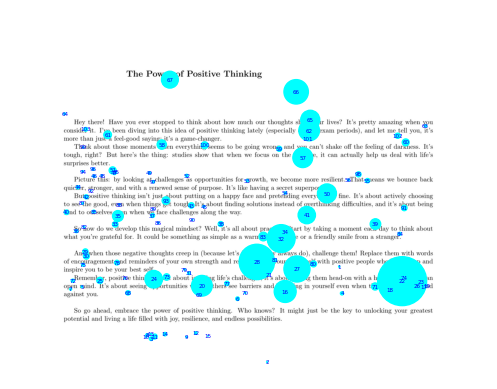

In [28]:
def generate_fixation_plot(image_path, fixations):
    img = Image.open(image_path)
    img = img.resize(DISPSIZE, Image.LANCZOS)

    plt.imshow(img)
    ax = plt.gca()

    # Plot each fixation
    for idx, data in enumerate(fixations):
        _, _, duration, x, y = data
        circle = plt.Circle((x, y), duration/150, color='cyan', fill = True)  # Adjust circle size factor as needed
        ax.add_patch(circle)
        ax.text(x, y, str(idx + 1), color='blue', fontsize=4, ha='center', va='center')

        # Show the plot
    plt.axis('off')  # To turn off the axis
    plt.savefig('fixation_plot.png',dpi=1000, bbox_inches='tight', pad_inches=0)

# plot the fixations on the given image , save the overlayed image and show it     
image_path = 'Image1.jpeg'
generate_fixation_plot(image_path, fixations)
image = Image.open('fixation_plot.png')
image.show()

# scanpath plot

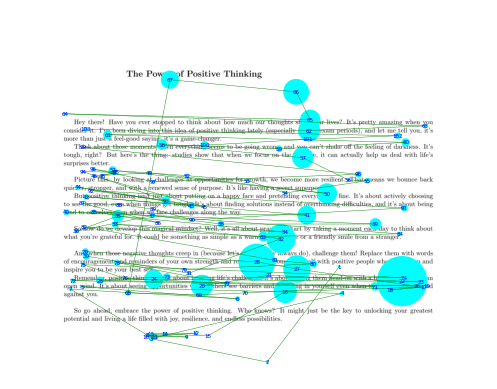

In [29]:
def generate_scanpath_plot(image_path, fixations):
    img = Image.open(image_path)
    img = img.resize(DISPSIZE, Image.LANCZOS)

    plt.imshow(img)
    ax = plt.gca()

    
    # Plot the scan path (lines connecting fixation points)
    for i in range(len(fixations)-1):
        _, _, _, x1, y1 = fixations[i]
        _, _, _, x2, y2 = fixations[i+1]
        ax.plot([x1, x2], [y1, y2], color='green', linewidth=0.3) 

    # Plot each fixation
    for idx, data in enumerate(fixations):
        _, _, duration, x, y = data
        circle = plt.Circle((x, y), duration/150, color='cyan', fill = True)  # Adjust circle size factor as needed
        ax.add_patch(circle)
        ax.text(x, y, str(idx + 1), color='blue', fontsize=4, ha='center', va='center')

        # Show the plot
    plt.axis('off')  # To turn off the axis
    plt.savefig('scanpath_plot.png',dpi=300, bbox_inches='tight', pad_inches=0)

# plot the scanpaths on the given image , save the overlayed image and show it     
image_path = 'Image1.jpeg'
generate_scanpath_plot(image_path, fixations)
image = Image.open('scanpath_plot.png')
image.show()

# Heatmap

### Normal Heatmap using seaborn

In [30]:
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image

def generate_heatmap(image_path, display_size, dataframe):
    
    image = Image.open(image_path)
    image= image.resize((display_size[0], display_size[1]), Image.LANCZOS)
    image_size = image.size
    
    x =  dataframe['PixelPointX']
    y = dataframe['PixelPointY']
    
    fig, ax = plt.subplots(figsize=(image_size[0]/100, image_size[1] / 100), frameon=False)

    ax.imshow(image)

    sns.kdeplot(x=x, y=y, cmap="hot", fill=True, alpha=0.6, ax=ax)

    ax.set_xlim(0, image_size[0])
    ax.set_ylim(image_size[1], 0)
    plt.axis('off')
    plt.savefig('heatmap_plot1.png', dpi=300, bbox_inches='tight', pad_inches=0)
    plt.close()

image_path = 'Image1.jpeg'
proccessed_csv_file_path = 'proccessed_gaze_data.csv'
gaze_df = pd.read_csv(proccessed_csv_file_path)
generate_heatmap(image_path, DISPSIZE, gaze_df)
image = Image.open('heatmap_plot1.png')
image.show()

/Users/andreas/miniconda3/envs/es/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/andreas/miniconda3/envs/es/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


### Heatmap using a matrix generation

In [31]:
import numpy as np
def gaussian(x, sx, y=None, sy=None):

    # square Gaussian if only x values are passed
    if y == None:
        y = x
    if sy == None:
        sy = sx
    # centers
    xo = x/2
    yo = y/2
    # matrix of zeros
    M = np.zeros([y,x],dtype=float)
    # gaussian matrix
    for i in range(x):
        for j in range(y):
            M[j,i] = np.exp(-1.0 * (((float(i)-xo)**2/(2*sx*sx)) + ((float(j)-yo)**2/(2*sy*sy)) ) )

    return M

def generate_heatmap_matrix(display_size, fixations):
    gwh = 200
    gsdwh = gwh/6
    gaus = gaussian(gwh,gsdwh)

    strt = gwh/2
    heatmapsize = int(display_size[1] + 2*strt), int(display_size[0] + 2*strt)
    heatmap = np.zeros(heatmapsize, dtype=float)
    # create heatmap
    for i in range(0,len(fixations[:])):
        # get x and y coordinates
        #x and y - indexes of heatmap array. must be integers
        x = strt + int(fixations[i][3]) - int(gwh/2)
        y = strt + int(fixations[i][4]) - int(gwh/2)
        # correct Gaussian size if either coordinate falls outside of
        # display boundaries
        if (not 0 < x < display_size[0]) or (not 0 < y < display_size[1]):
            hadj=[0,gwh];vadj=[0,gwh]
            if 0 > x:
                hadj[0] = abs(x)
                x = 0
            elif dispsize[0] < x:
                hadj[1] = gwh - int(x-display_size[0])
            if 0 > y:
                vadj[0] = abs(y)
                y = 0
            elif dispsize[1] < y:
                vadj[1] = gwh - int(y-display_size[1])
            # add adjusted Gaussian to the current heatmap
            try:
                heatmap[int(y):int(y+vadj[1]),int(x):int(x+hadj[1])] += \
                    gaus[int(vadj[0]):int(vadj[1]),int(hadj[0]):int(hadj[1])] * fixations[i][2]
            except:
                # fixation was probably outside of display
                pass
        else:
            # add Gaussian to the current heatmap
            heatmap[int(y):int(y+gwh),int(x):int(x+gwh)] += gaus * fixations[i][2]
    # resize heatmap
    heatmap = heatmap[int(strt):int(display_size[1]+strt),int(strt):int(display_size[0]+strt)]
    # remove zeros
    lowbound = np.mean(heatmap[heatmap>0])
    heatmap[heatmap<lowbound] = np.nan
    return heatmap

In [32]:
display_size = DISPSIZE
heatmap = generate_heatmap_matrix(display_size = display_size, fixations = fixations)

image_path = 'Image1.jpeg'
img = Image.open(image_path)
img = img.resize(display_size, Image.LANCZOS)

plt.imshow(img)
ax = plt.gca()

ax.imshow(heatmap, cmap='jet', alpha=0.5)
plt.axis('off')
plt.savefig("heatmap_plot_2.png", dpi=1000, bbox_inches='tight', pad_inches=0)
plt.close()

image = Image.open('heatmap_plot_2.png')
image.show()

### opacity map generation

In [33]:
def generate_opacity(np_image, heatmap):
    for i in range(np_image.shape[0]):
        for j in range(np_image.shape[1]):
            for k in range(np_image.shape[2]):
                if np.isnan(heatmap[i][j]):
                    np_image[i][j][k] = 0
    return np_image

In [34]:

display_size = DISPSIZE

heatmap = generate_heatmap_matrix(display_size = display_size, fixations = fixations)
image_path = 'Image1.jpeg'
img = Image.open(image_path)
img = img.resize(display_size, Image.LANCZOS)

numpy_array = np.array(img)

numpy_array_modified = generate_opacity(numpy_array, heatmap)


img = Image.fromarray(numpy_array_modified)
plt.imshow(img)
plt.axis('off')
plt.savefig("opacity_plot.png", dpi=1000, bbox_inches='tight', pad_inches=0)
plt.close()

image = Image.open('opacity_plot.png')
image.show()